# freecodecamp - Book recommendations -


<div class="alert alert-block alert-info">
<b>freecodecamp:</b><br><br>In this challenge, you will create a book recommendation algorithm using K-Nearest Neighbors.<br><br>You will use the Book-Crossings dataset. This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users.<br><br>After importing and cleaning the data, use NearestNeighbors from sklearn.neighbors to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures the distance to determine the “closeness” of instances.<br><br>Create a function named get_recommends that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.<br><br>The first three code cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.
</div>

> Required packages, try to use only the packages listed here!

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

> The second code cell downloads the data and sets the filenames.
>
> After downloading and unpacking, the following *.csv files are created in the root directory:
>
>     BX-Book-Ratings.csv
>     BX-Books.csv
>     BX-Users.csv

<div class="alert alert-block alert-info">
<b>Tip:</b> After the *.zip file is downloaded and unpacked, commend these two lines:<br>
<code>!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip</code> <br>and <br>
<code>!unzip book-crossings.zip</code><br>to avoid downloading and unpacking the same files again.
</div>

In [2]:
# get data files
# !wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

# !unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

> Creating data frames

In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

### Exploratory Data Analysis

Before building the recommendation model, we check the data frames for missing values, duplicate values, column data types and finally run some statistics to filter out illogical data.

In [4]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [5]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271379 non-null  object
 1   title   271379 non-null  object
 2   author  271377 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB


It seems that their is now missing value and all columns have the right data type.

In [6]:
df_books.describe()

,isbn,title,author
count,271379,271379,271377
unique,271379,242154,102041
top,0195153448,Selected Poems,Agatha Christie
freq,1,27,632


In [7]:
1-round(242154/271379,3)

0.10799999999999998

All 271379 books listed have a unique ISBN number, so there are no duplicates within the data frame. However, 10.8% of the book titles are listed at least twice. This could be due to different editions of the same book, common book titles, or something else. Some books are considered classic literature and are reprinted again and again, sometimes rewritten so that the audience can better understand the context of the book, as language changes over time and our understanding of old expressions is lost.<br> In this case, different spellings (lower or upper case) are excluded by the unique ISBN.

In [8]:
equal_title = df_books[df_books["title"].duplicated(keep=False)]
print(equal_title.shape)
print(equal_title["title"].value_counts())

(49132, 3)
title
Selected Poems                                                                             27
Little Women                                                                               24
Wuthering Heights                                                                          21
Adventures of Huckleberry Finn                                                             20
Dracula                                                                                    20
                                                                                           ..
The Burning Season: The Murder of Chico Mendes and the Fight for the Amazon Rain Forest     2
Die Unendliche Geschichte                                                                   2
A Midnight Clear: Stories for the Christmas Season                                          2
Founding Brothers: The Revolutionary Generation                                             2
Fight Club : A Novel                       

In [9]:
equal_title[equal_title["title"]=="Selected Poems"].sort_values("author")

,isbn,title,author
215281,0156003961,Selected Poems,Carl Sandburg
202459,0679765654,Selected Poems,Daniel Halpern
202754,0906427851,Selected Poems,Denise Levertov
156902,0871401541,Selected Poems,E. E. Cummings
232076,006093168X,Selected Poems,Edna St. Vincent Millay
251709,0460871501,Selected Poems,Elizabeth Barrett Browning
226037,0395320461,Selected Poems,Galway Kinnell
106890,0060931744,Selected Poems,Gwendolyn Brooks
158321,0060909897,Selected Poems,Gwendolyn Brooks
198971,1852240954,Selected Poems,Jenny Joseph


In [10]:
equal_title[equal_title["title"]=="Adventures of Huckleberry Finn"]

,isbn,title,author
2354,0835902242,Adventures of Huckleberry Finn,Mark Twain
26462,059043389X,Adventures of Huckleberry Finn,Mark Twain
27188,0451519124,Adventures of Huckleberry Finn,Mark Twain
30727,0451523733,Adventures of Huckleberry Finn,Mark Twain
38300,0448110008,Adventures of Huckleberry Finn,Mark Twain
42374,0520237714,Adventures of Huckleberry Finn,Mark Twain
43651,0590408011,Adventures of Huckleberry Finn,Mark Twain
85306,0448058006,Adventures of Huckleberry Finn,Mark Twain
101572,0679448896,Adventures of Huckleberry Finn,Mark Twain
105259,0449912728,Adventures of Huckleberry Finn,Mark Twain


As might be expected, classics such as <I>Adventures of Huckleberry Finn</I> have multiple print versions, or other books with a more common name have different authors. Since this is not part of the task, we will not explore this further, but it might be interesting to see how recommendations for a book with multiple print versions change depending on the version (years) and generation that reads and evaluates it.<br><br>Before moving on to the next step, we also review the user recommendations dataframe.

In [11]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


In [12]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


Again, the data frame seems to be formatted correctly. The users have an "id" represented by an integer, the ISBN number is an object as before, only the rating could also be represented by an integer instead of a float.

In [13]:
df_ratings.describe()

,user,rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [14]:
sorted(df_ratings["rating"].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

From the quick statistics of the rating data framework, we can get the information that we have about 1.15 million user ratings for our books. From the rating column, we can see that the recommendations range from 0 (Not Recommended) to 10 (Highly Recommended), and from the quantiles, we can see that the recommendations tend to be negative (0).

Text(0, 0.5, 'Frequency in percentage, (%)')

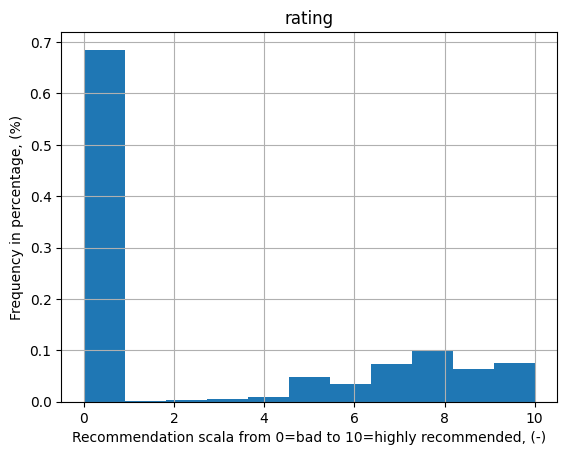

In [15]:
fig, ax = plt.subplots()
df_ratings.hist(column="rating", bins=11, density=True, ax=ax)
ax.set_xlabel("Recommendation scala from 0=bad to 10=highly recommended, (-)")
ax.set_ylabel("Frequency in percentage, (%)")

This chart reinforces the point that the ratings are more negative than positive.<br><br>Let's investigate this behaviour deeper to understand this, by looking how the users rate.

In [16]:
count_user_rating = df_ratings.groupby("user")["rating"].count().reset_index()
# print(count_user_rating["rating"].max())
count_user_rating.head()

,user,rating
0,2,1
1,7,1
2,8,18
3,9,3
4,10,2


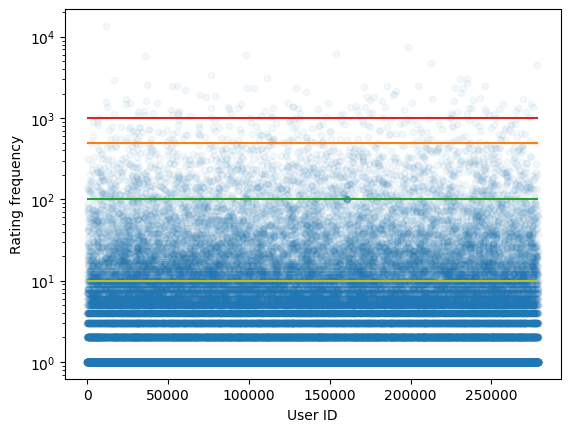

In [17]:
fig, ax = plt.subplots()
count_user_rating.plot.scatter(x="user", y="rating", logy=True, alpha=0.05, ax=ax)
ax.hlines(y=[10, 100, 500, 1000], xmin=0, xmax=df_ratings["user"].max(),
          colors=["tab:olive", "tab:green", "tab:orange", "tab:red"])
ax.set_xlabel("User ID")
ax.set_ylabel("Rating frequency")
# ax.legend(["User frequency", "10 reviews", "100 reviews", "500 reviews", "1000 reviews"])
plt.show()

Let's assume that the average ambitious reader reads 1 book per month, which equates to 12 books per year, and let's say just under 1000 books in a lifetime. And if we assume that only about 50% of these books are rated (orange line), we can assume that users with more than 1000 recommendations can be bots!<br><br>To achieve statistical significance, <I>freecodecamp</I> would like us to remove users with less than 200 reviews from the dataset. This is necessary for the K-Nearest Neighbors (KNN) classifier. Unfortunately, this task allows users with more than 1000 ratings without questioning this further.<br><br>So we will also take them into account.

In [18]:
users_to_remove = count_user_rating[count_user_rating["rating"] < 200]["user"].tolist()

In [19]:
# check
count_user_rating[~count_user_rating["user"].isin(users_to_remove)].describe()

,user,rating
count,905.000000,905.000000
mean,143504.490608,582.934807
std,78757.001409,769.910460
min,254.000000,200.000000
25%,79441.000000,258.000000
50%,143792.000000,360.000000
75%,211919.000000,614.000000
max,278418.000000,13602.000000


In [20]:
print("Amount of statistical unsignificant users:", len(users_to_remove))
print("Percentage of all users who give less than 200 reviews:", round(len(users_to_remove)/count_user_rating.shape[0], 4) * 100)

Amount of statistical unsignificant users: 104378
Percentage of all users who give less than 200 reviews: 99.14


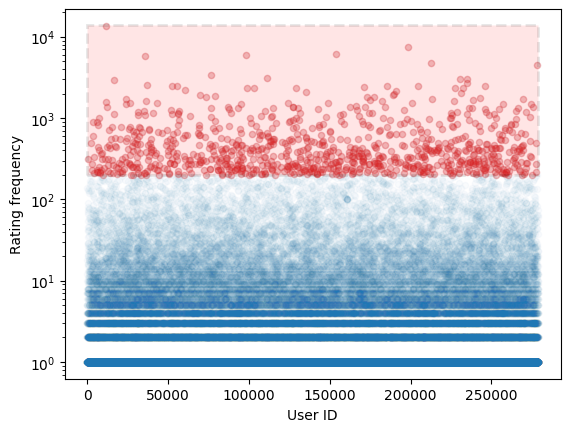

In [21]:
fig, ax = plt.subplots()
count_user_rating.plot.scatter(x="user", y="rating", logy=True, alpha=0.025, ax=ax)
count_user_rating[~count_user_rating["user"].isin(users_to_remove)].plot.scatter(x="user", y="rating", color="tab:red", logy=True, alpha=0.25, ax=ax)
ax.set_xlabel("User ID")
ax.set_ylabel("Rating frequency")
rect = mpatches.Rectangle((0, 200), count_user_rating["user"].max(), count_user_rating["rating"].max(), 
                          # fill=False,
                          linestyle="dashed",
                          linewidth=2,
                          edgecolor="black",
                          alpha=0.1,
                          facecolor="red")
plt.gca().add_patch(rect)
plt.show()

According to <I>freecodecamp</I>'s problem description for this task, <b>only users with more than 200 ratings should be considered</b>, which is only 0.86% of the data.

In [22]:
count_book_rating = df_ratings.groupby("isbn")["rating"].count().reset_index()
#print("ISBN with the highest reviews:", count_book_rating[count_book_rating["rating"] == count_book_rating["rating"].max()]["isbn"].to_list())
print("ISBN with the highest reviews:\n", count_book_rating[count_book_rating["rating"] == count_book_rating["rating"].max()])
#print("Number of reviews:", count_book_rating["rating"].max())
count_book_rating.head()

ISBN with the highest reviews:
               isbn  rating
247408  0971880107    2502


,isbn,rating
0,0330299891,2
1,0375404120,2
2,0586045007,1
3,9022906116,2
4,9032803328,1


In [23]:
df_books[df_books["isbn"]=="0971880107"]

,isbn,title,author
26,0971880107,Wild Animus,Rich Shapero


Let's write a function to evaluate a simple statistic overview for a given ISBN number!

In [24]:
def rating_stats(arg, density=True):
    selected_df = df_ratings[df_ratings["isbn"].isin(arg)] #== arg]
    piv = selected_df.pivot_table(values="rating", index="isbn", columns="rating", aggfunc="count", fill_value=0)
    display("Quick statistics for:", piv)

    fig, ax = plt.subplots()
    for isbn in arg:
        #display(df_ratings[df_ratings["isbn"].isin([isbn])])
        label = df_books[df_books["isbn"].isin([isbn])]["title"]
        df_ratings[df_ratings["isbn"].isin([isbn])].hist(column="rating", density=density, grid=False, histtype="step", bins=11, ax=ax, label=label)

#    df_ratings[df_ratings["isbn"].isin(arg)].hist(column="rating", ax=ax)
    ax.set_xlabel("Rating scale (-)")
    ax.set_ylabel("Density (%)")
    fig.tight_layout()
    fig.get_figure().gca().set_title("")
    plt.legend()
    plt.show()

'Quick statistics for:'

rating,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
isbn,,,,,,,,,,,
0345313860,158,0,0,3,2,11,11,18,39,29,30
0971880107,1921,74,82,87,58,88,66,60,40,16,10


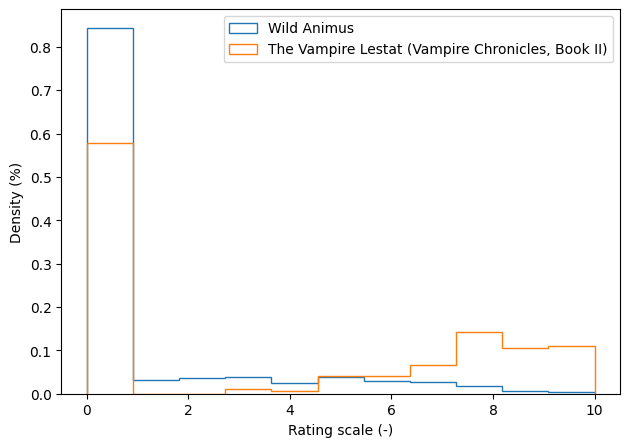

In [25]:
rating_stats(["0971880107", "0345313860"])

The book with the most reviews is <I>Wild Animus</I> from <I>Rich Shapero</I>. According to the histogram, his book is either not very popular or bots have rated it negatively.<br>The Book "The Vampire Lestat" is just a random book to show/validate that the function is dynamic and can take as many arguments as you want, but remember that more is almost never the best way - as much as possible, as little as necessary -.

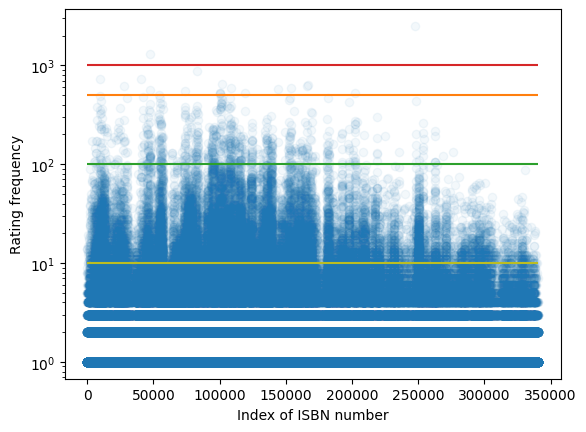

In [26]:
fig, ax = plt.subplots()
ax.scatter(x=count_book_rating.index, y=count_book_rating["rating"], alpha=0.05)
ax.set_yscale("log")
ax.hlines(y=[10, 100, 500, 1000], xmin=0, xmax=len(df_ratings["isbn"].unique()),
          colors=["tab:olive", "tab:green", "tab:orange", "tab:red"])
ax.set_xlabel("Index of ISBN number")
ax.set_ylabel("Rating frequency")
# ax.legend(["User frequency", "10 reviews", "100 reviews", "500 reviews", "1000 reviews"])
plt.show()

This chart shows that most books have fewer than 10 recommendations and another large number have between 10 and 100 recommendations. Only a manageable amount of books have more than 100 ratings.<br><b>To ensure statistical significance, books with less than 100 ratings should be removed.</b><br><br>The horizontal lines correspond to those in the previous illustration.

In [27]:
books_to_remove = count_book_rating[count_book_rating["rating"] < 100]["isbn"].tolist()

In [28]:
# check
count_book_rating[~count_book_rating["isbn"].isin(books_to_remove)].describe()

,rating
count,731.000000
mean,189.413133
std,140.617548
min,100.000000
25%,120.000000
50%,148.000000
75%,208.000000
max,2502.000000


In [29]:
print("Amount of statistical unsignificant books:", len(books_to_remove))
print("Percentage of all books with less than 200 reviews:", round(len(books_to_remove)/count_book_rating.shape[0], 4) * 100)

Amount of statistical unsignificant books: 339825
Percentage of all books with less than 200 reviews: 99.79


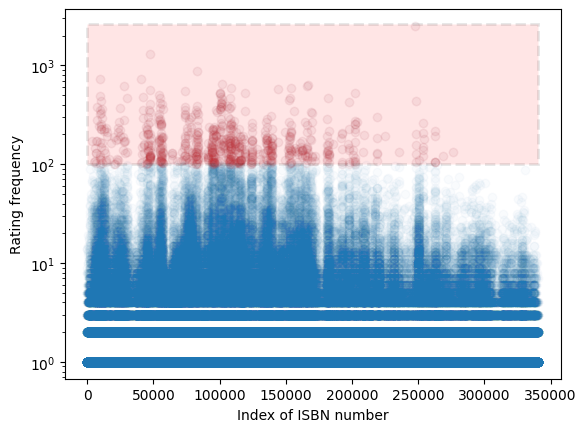

In [30]:
fig, ax = plt.subplots()
ax.scatter(x=count_book_rating.index, y=count_book_rating["rating"], alpha=0.025)
ax.scatter(x=count_book_rating[~count_book_rating["isbn"].isin(books_to_remove)].index,
           y=count_book_rating[~count_book_rating["isbn"].isin(books_to_remove)]["rating"],
           color="tab:red", alpha=0.05)
ax.set_xlabel("User ID")
ax.set_ylabel("Rating frequency")
ax.set_yscale("log")

ax.set_xlabel("Index of ISBN number")
ax.set_ylabel("Rating frequency")
rect = mpatches.Rectangle((0, 100), count_book_rating.shape[0], count_book_rating["rating"].max(), 
                          # fill=False,
                          linestyle="dashed",
                          linewidth=2,
                          edgecolor="black",
                          alpha=0.1,
                          facecolor="red")
plt.gca().add_patch(rect)
plt.show()

According to <I>freecodecamp</I>'s problem description for this project, only books with more than 100 ratings should be considered, which is only 0.21% of the data.<br><br>I also noticed that the “isbn” column does not exactly correspond to the <b>International Standard Book Number</b>. The ISBN consists of 10 (old) or 13 (new) digits, and you can easily convert between 10 and 13 digits by adding or subtracting the first 3 digits (978) and replacing the old check digit with the newly calculated EAN check digit.<br>In this context, we treat the available numbers as a unique identification number (UIN) and not as an ISBN.  

In [31]:
df_ratings[df_ratings["isbn"] == "0330299891"]

,user,isbn,rating
344509,82164,0330299891,0.0
729864,176230,0330299891,0.0
975072,235105,0330299891,0.0


In [32]:
df_ratings[df_ratings["isbn"] == "0 907 062 008"]

,user,isbn,rating
67343,13874,0 907 062 008,10.0
172329,37527,0 907 062 008,0.0
223393,52203,0 907 062 008,0.0
375280,90232,0 907 062 008,0.0
571523,137397,0 907 062 008,10.0
673630,163824,0 907 062 008,0.0
778729,188658,0 907 062 008,10.0
855280,206865,0 907 062 008,0.0


In [33]:
df_ratings[df_ratings["isbn"] == "000000000"]

,user,isbn,rating
27016,6360,000000000,0.0
59325,11795,000000000,0.0
92727,20859,000000000,0.0
215368,50321,000000000,0.0
237901,55488,000000000,0.0
299926,71285,000000000,0.0
450173,107899,000000000,0.0
450240,107951,000000000,0.0
498883,120548,000000000,6.0
571366,137348,000000000,0.0


If one observes the course of the evaluations, the suspicion is strengthened that predominantly negative was evaluated. Now the question arises what causes this behavior or whether there are perhaps users who deliberately give bad ratings. It is similar with the UID "0 907 062 008". Here we find either extremely bad or extremely good ratings. Even if this book is not considered here due to the problem description, the question arises how many of these evaluations are really serious evaluations and which were only created to under or overrate a book.<br><br>In an update I might go deeper in this topic, so let's continue the <I>freecodecamp</I> challange.

### Solving the challenge

> Create a book recommendation algorithm using <b>Unsupervised Learning</b> with K-Nearest Neighbors

Let's continue with the challenge by creating a reduced data frame that includes only users with more than 200 and books with more than 100 ratings. Finally, merge it with the Books data frame to include the title and author information as well.

In [34]:
df_ratings_reduced = df_ratings[~df_ratings["user"].isin(users_to_remove) & ~df_ratings["isbn"].isin(books_to_remove)]

In [35]:
# merge reduced ratings dataframe with the books dataframe
df = df_ratings_reduced.merge(df_books, on="isbn")

In [36]:
df.head()

,user,isbn,rating,title,author
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner


In [37]:
df[["title", "author"]].describe()

,title,author
count,49517,49517
unique,673,319
top,Wild Animus,John Grisham
freq,365,1777


In [38]:
df[["title", "author"]].head()

,title,author
0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner


In [39]:
# df["rating"] = df["rating"].astype(dtype="int8")  # to reduce memory usage!

<div class="alert alert-block alert-warning">
<b>Idea:</b> <I>We have to be careful here, because on the one hand we have individual ratings (depending on the user) for different books, which can lead to multiple mentions for the same book title. On the other hand, some books are listed multiple times, see in the moddle of this notebook above.</I>
</div>

<br>Now the question arises, which columns are really necessary to solve the <I>freecodecamp</I> problem? We know that we need the book title (argument of the <code>get_recommends</code> function) to get a recommendation for similar book titles. We also need the ratings of the individual users. The idea is that the KNN classification should recommend books that have been rated by users similarly to the one we are looking for.<br>To do this, we first create a pivot table with the user <b>rating</b> as value, the book <b>title</b> as index (alternatively you could also use the isbn, but you have to extend the <code>get_recommends</code> function for this) and the <b>user</b> for the columns.

In [40]:
# df_pivot = df_ratings_reduced.pivot_table(values="rating", index="isbn", columns="rating", aggfunc="count").fillna(0)
df_pivot = df.pivot_table(values="rating", index="title", columns="user", fill_value=0)
df_pivot.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1st to Die: A Novel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2nd Chance,0,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4 Blondes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# merged_df = df_pivot.reset_index().merge(df_books[["isbn", "title"]], on="isbn")
# col = merged_df.columns[1:].to_list()
# features_df = merged_df[col]
# features_df.set_index("title", inplace=True)
# features_df.head()

For more efficient calculation and less memory footprint, we need to transform the values of the dataframe into a scipy sparse matrix. See also: 
- https://hippocampus-garden.com/pandas_sparse/
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

Where data, row and col indice satisfy the relationship: $a\left[row_{indice}\left[k\right], col_{indice}\left[k\right]\right] = data\left[k\right]$

In [42]:
features_sparse = csr_matrix(df_pivot)  # (features_df)

> Building the K-Nearest Neighbors model

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics

The goal is to build a model which find the following books:

```Python
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
 [
  ['Catch 22', 0.793983519077301],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479],
  ['Interview with the Vampire', 0.7345068454742432],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
 ]
]
```

In [43]:
list_to_find = ['The Queen of the Damned (Vampire Chronicles (Paperback))',
                'Catch 22',
                'The Witching Hour (Lives of the Mayfair Witches)',
                'Interview with the Vampire',
                'The Tale of the Body Thief (Vampire Chronicles (Paperback))',
                'The Vampire Lestat (Vampire Chronicles, Book II)'
               ]

df_books[df_books["title"].isin(list_to_find)]

,isbn,title,author
292,0684833395,Catch 22,Joseph Heller
608,0345313860,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE
1131,0345384466,The Witching Hour (Lives of the Mayfair Witches),ANNE RICE
2526,0345337662,Interview with the Vampire,Anne Rice
2527,0345351525,The Queen of the Damned (Vampire Chronicles (P...,Anne Rice
2885,034538475X,The Tale of the Body Thief (Vampire Chronicles...,Anne Rice
7528,0394587863,The Witching Hour (Lives of the Mayfair Witches),ANNE RICE
21551,0440204399,Catch 22,Joseph Heller
30498,0345310594,Interview with the Vampire,Anne Rice
72840,0833563505,The Queen of the Damned (Vampire Chronicles (P...,Anne Rice


In [44]:
df[df["title"].isin(list_to_find)]["title"].unique()

array(['The Queen of the Damned (Vampire Chronicles (Paperback))',
       'The Vampire Lestat (Vampire Chronicles, Book II)',
       'The Witching Hour (Lives of the Mayfair Witches)',
       'The Tale of the Body Thief (Vampire Chronicles (Paperback))',
       'Catch 22', 'Interview with the Vampire'], dtype=object)

'Quick statistics for:'

rating,0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
isbn,,,,,,,,,,
0345310594,0,0,0,0,1,0,0,0,0,1
0345313860,158,0,3,2,11,11,18,39,29,30
0345337662,276,2,3,2,20,19,46,52,44,42
0345351525,173,2,1,2,11,12,21,19,19,13
0345384466,146,0,2,2,8,7,11,23,25,19
034538475X,103,1,1,3,16,8,18,21,12,10
0394587863,16,0,0,1,1,0,1,3,3,6
0440204399,17,0,0,0,3,1,1,3,3,4
0684833395,55,1,1,1,5,0,4,11,14,16


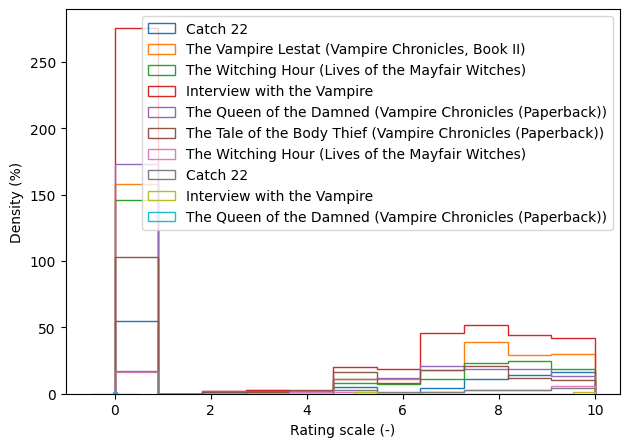

In [45]:
rating_stats(df_books[df_books["title"].isin(list_to_find)]["isbn"], density=False)

Fortunately, all the books from the task are in the data frame (<code>df</code>) created. So far we are on the right track.<br><br>Let us now create the KNN model and fit it to the sparse matrix.

In [46]:
model = NearestNeighbors(metric="cosine", n_neighbors=6)  # metric is cosine by problem describtion, 5 neighbours + the title in the search
model.fit(features_sparse)

NearestNeighbors(metric='cosine', n_neighbors=6)

And now let's build the function <code>get_recommends()</code>.

> Notice that the data returned from <code>get_recommends()</code> is a list. The first element in the list is the book title passed into the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed into the function.

In [47]:
# function to return recommended books - this will be tested
def get_recommends(title):
    try:
        book = df_pivot.loc[[title]]
    except:
        print("The book you are looking for is not in the database or is incorrectly written!")

    neigh_distance, neigh_indice = model.kneighbors(X=book.values)

    recommended_books = []

    for i in reversed(range(1, 6)):
        recommended_books.append([df_pivot.iloc[neigh_indice.flatten()].index[i], neigh_distance.flatten()[i]])

    recommended_books = [title, recommended_books]

    return recommended_books

In [48]:
get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835419270879],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448657003312193],
  ['Interview with the Vampire', 0.7345068863988313],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))',
   0.5376338446489461],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178411864186413]]]

Compare with the <I>freecodecamp</I> challenge:

```Python
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
 [
  ['Catch 22', 0.793983519077301],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479],
  ['Interview with the Vampire', 0.7345068454742432],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
 ]
]
```

we get quite good results, the distances are almost identical.<br><br>Finally we test our function on the availabel test function.

In [49]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016210581447822], ['The Weight of Water', 0.7708583572697412], ['The Surgeon', 0.7699410973804288], ['I Know This Much Is True', 0.7677075092617776], ['The Lovely Bones: A Novel', 0.7234864549790632]]]
You passed the challenge! 🎉🎉🎉🎉🎉
